In [109]:
import community as community_louvain
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import numpy as np
import random
import ndlib.models.ModelConfig as mc
import ndlib.models.epidemics as ep
import matplotlib.pyplot as plt
import pprint

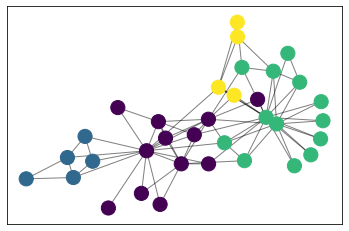

In [110]:
G=nx.Graph()
gr=pd.read_csv('karate.csv')
#gr=pd.read_csv('dolphin.csv')
#gr=pd.read_csv('football.csv')
edge=[(gr['Source'][i],gr['Destination'][i]) for i in range(0,len(gr['Source']))]
G.add_edges_from(edge)
node=max([max(x[0],x[1]) for x in edge])
# compute the best partition
# partition contains color of each node
partition = community_louvain.best_partition(G)

# visualization of clusters
pos = nx.spring_layout(G)
cmap = cm.get_cmap('viridis', max(partition.values()) + 1)
nx.draw_networkx_nodes(G, pos, partition.keys(), node_size=200,cmap=cmap, node_color=list(partition.values()),)
nx.draw_networkx_edges(G, pos, alpha=0.5)
plt.show()

In [111]:
# Generating gateEdges
# gateEdges contains edges--> [(a,b),(b,c)]
gateEdges=[]
for x in edge:
    if(partition[x[0]]!=partition[x[1]]):
        gateEdges.append(x)

# Generating gate nodes 
gateNodesDict={}

for tup in gateEdges:
    gateNodesDict[tup[0]]=1
    gateNodesDict[tup[1]]=1

gateNodesList=list(gateNodesDict.keys())

print("Gateway graph nodes:",gateNodesList)
for x in gateNodesList:
    for y in gateNodesList:
        if(x==y or ((x,y) in gateEdges) or ((y,x) in gateEdges)):
            continue
        else:
            if(partition[x]==partition[y]):
                if((x,y) in edge or (y,x) in edge):
                    gateEdges.append((x,y))

Gateway graph nodes: [5, 1, 6, 7, 9, 3, 11, 26, 24, 28, 25, 29, 31, 2, 32, 33, 34, 10, 14, 20]


In [112]:
# Gate graph
# This is the gate way graph
# gate
tot_g=[]
for i in range(0,500):
    g = nx.Graph()
    tot_g.append(g)
    attr = {(u, v): {"weight": round(random.uniform(0,1),2)} for (u, v) in g.edges()}
    nx.set_edge_attributes(g, attr)

for k in range(0,500):
    tot_g[k].add_nodes_from(gateNodesList)
    for i in range(0,len(gateEdges)):
        tot_g[k].add_edge(gateEdges[i][0],gateEdges[i][1],weight=round(random.uniform(0,1),2))

In [113]:
#BCS Score
def BCS(G,nodes):
    BCS_=[0]*(nodes+1)
    for i in G:
        x=(nx.betweenness_centrality(i,weight='weight'))
        #print(x)
        for j in x:
            BCS_[j]+=(1/10)*x[j]
    #BCS_=[round(i,3) for i in BCS_]
    return BCS_
BCSSS=BCS(tot_g,max([max(a[0],a[1]) for a in gateEdges]))
BCS_value={}
for i in range(1,max([max(a[0],a[1]) for a in gateEdges])+1):
    BCS_value[i]=BCSSS[i]
BCS_value=(sorted(BCS_value.items(), key=lambda x: x[1],reverse=True))
print(BCS_value)

[(1, 22.48784600389865), (34, 14.803313840155948), (3, 11.779502923976628), (32, 9.532729044834307), (33, 5.964649122807011), (9, 5.267904483430796), (2, 4.586184210526315), (28, 4.083284600389861), (14, 3.444639376218325), (24, 2.9420565302144257), (31, 2.5213693957115013), (20, 2.205677387914232), (7, 1.9694688109161802), (6, 1.9524366471734895), (5, 1.8022173489278752), (29, 1.7673245614035085), (11, 1.7337475633528283), (25, 1.647465886939572), (26, 1.4140399610136454), (10, 0.5536062378167643), (4, 0), (8, 0), (12, 0), (13, 0), (15, 0), (16, 0), (17, 0), (18, 0), (19, 0), (21, 0), (22, 0), (23, 0), (27, 0), (30, 0)]


In [114]:
# Model selection - diffusion time
model = ep.SIModel(G)

# Model Configuration
cfg = mc.Configuration()
cfg.add_model_parameter('beta', 0.03)
cfg.add_model_parameter("fraction_infected", 1/max([max(x[0],x[1]) for x in edge]))
model.set_initial_status(cfg)

# Simulation execution
iterations = model.iteration_bunch(200)

#Mapping diffusion_time_to_each_node
time_of_diffusion={}
for i in range(1,node+1):
    time_of_diffusion[i]=-1
for i in iterations:
    for j in i['status']:
        if(i['status'][j]==1):
            time_of_diffusion[j]=i['iteration']

100%|██████████| 200/200 [00:00<00:00, 3029.45it/s]


In [115]:
print(time_of_diffusion)

{1: 14, 2: 16, 3: 1, 4: 5, 5: 26, 6: 44, 7: 21, 8: 0, 9: 6, 10: 6, 11: 24, 12: 26, 13: 6, 14: 5, 15: 22, 16: 18, 17: 33, 18: 61, 19: 8, 20: 16, 21: 62, 22: 28, 23: 23, 24: 34, 25: 31, 26: 21, 27: 45, 28: 37, 29: 14, 30: 23, 31: 28, 32: 17, 33: 14, 34: 7}


In [116]:
sensor_nodes=[BCS_value[i][0] for i in range(0,3)]
print(sensor_nodes)
print(gateNodesList)
print(len(gateEdges))

[1, 34, 3]
[5, 1, 6, 7, 9, 3, 11, 26, 24, 28, 25, 29, 31, 2, 32, 33, 34, 10, 14, 20]
46


In [117]:
delta_t=[]
min_v=min([time_of_diffusion[i] for i in sensor_nodes])
min_n=-1
for i in sensor_nodes:
    if(time_of_diffusion[i]==min_v):
        min_n=i
        break
delta_t=[(i,abs(time_of_diffusion[i]-min_v)) for i in sensor_nodes if(i!=min_n)]
print(delta_t)

[(1, 13), (34, 6)]


In [118]:
timeOfDiffusions=[]
for i in tot_g:
    print(len(i.edges()))
    # Model selection - diffusion time
    model = ep.SIModel(i)

    # Model Configuration
    cfg = mc.Configuration()
    cfg.add_model_parameter('beta', 0.03)
    cfg.add_model_parameter("fraction_infected", 1/max([max(x[0],x[1]) for x in edge]))
    model.set_initial_status(cfg)

    # Simulation execution
    iterations = model.iteration_bunch(200)

    #Mapping diffusion_time_to_each_node
    time_of_diffusion={}
    for i in range(1,node+1):
        time_of_diffusion[i]=-1
    for i in iterations:
        for j in i['status']:
            if(i['status'][j]==1):
                time_of_diffusion[j]=i['iteration']
    timeOfDiffusions.append(len(time_of_diffusion))

100%|██████████| 200/200 [00:00<00:00, 3773.88it/s]

46
46
46



  0%|          | 0/200 [00:00<?, ?it/s]

46
46
46
46


  0%|          | 0/200 [00:00<?, ?it/s]

46
46
46
46


  0%|          | 0/200 [00:00<?, ?it/s]

46
46
46
46


  0%|          | 0/200 [00:00<?, ?it/s]

46
46
46
46


  0%|          | 0/200 [00:00<?, ?it/s]

46
46
46
46


  0%|          | 0/200 [00:00<?, ?it/s]

46
46
46
46


  0%|          | 0/200 [00:00<?, ?it/s]

46
46
46
46


  0%|          | 0/200 [00:00<?, ?it/s]

46
46
46


  0%|          | 0/200 [00:00<?, ?it/s]

46
46
46
46


  0%|          | 0/200 [00:00<?, ?it/s]

46
46
46
46


100%|██████████| 200/200 [00:00<00:00, 5883.07it/s]

46
46
46
46
46



  0%|          | 0/200 [00:00<?, ?it/s]

46
46
46
46


  0%|          | 0/200 [00:00<?, ?it/s]

46
46
46
46


  0%|          | 0/200 [00:00<?, ?it/s]

46
46
46
46
46


  0%|          | 0/200 [00:00<?, ?it/s]

46
46
46
46
46


  0%|          | 0/200 [00:00<?, ?it/s]

46
46
46
46
46


  0%|          | 0/200 [00:00<?, ?it/s]

46
46
46
46


  0%|          | 0/200 [00:00<?, ?it/s]

46
46
46
46


  0%|          | 0/200 [00:00<?, ?it/s]

46
46
46
46
46


  0%|          | 0/200 [00:00<?, ?it/s]

46
46
46
46
46


  0%|          | 0/200 [00:00<?, ?it/s]

46
46
46
46
46


  0%|          | 0/200 [00:00<?, ?it/s]

46
46
46
46
46


100%|██████████| 200/200 [00:00<00:00, 6668.26it/s]

46
46
46
46
46



  0%|          | 0/200 [00:00<?, ?it/s]

46
46
46
46
46


100%|██████████| 200/200 [00:00<00:00, 5883.56it/s]

46
46
46
46
46



  0%|          | 0/200 [00:00<?, ?it/s]

46
46
46
46
46


100%|██████████| 200/200 [00:00<00:00, 5263.64it/s]

46
46
46
46



100%|██████████| 200/200 [00:00<00:00, 5263.47it/s]

46
46
46
46



100%|██████████| 200/200 [00:00<00:00, 3704.09it/s]


46
46
46
46


  0%|          | 0/200 [00:00<?, ?it/s]

46
46
46
46


  0%|          | 0/200 [00:00<?, ?it/s]

46
46
46
46


  0%|          | 0/200 [00:00<?, ?it/s]

46
46
46


  0%|          | 0/200 [00:00<?, ?it/s]

46
46
46


  0%|          | 0/200 [00:00<?, ?it/s]

46
46
46


  0%|          | 0/200 [00:00<?, ?it/s]

46
46
46


  0%|          | 0/200 [00:00<?, ?it/s]

46
46
46


  0%|          | 0/200 [00:00<?, ?it/s]

46
46
46


  0%|          | 0/200 [00:00<?, ?it/s]

46
46
46
46


100%|██████████| 200/200 [00:00<00:00, 3637.02it/s]

46
46
46



  0%|          | 0/200 [00:00<?, ?it/s]

46
46
46
46


  0%|          | 0/200 [00:00<?, ?it/s]

46
46
46


  0%|          | 0/200 [00:00<?, ?it/s]

46
46
46


  0%|          | 0/200 [00:00<?, ?it/s]

46
46
46
46


  0%|          | 0/200 [00:00<?, ?it/s]

46
46
46
46


  0%|          | 0/200 [00:00<?, ?it/s]

46
46
46
46


100%|██████████| 200/200 [00:00<00:00, 5716.02it/s]


46
46
46
46
46

  0%|          | 0/200 [00:00<?, ?it/s]


46
46
46
46
46


  0%|          | 0/200 [00:00<?, ?it/s]

46
46
46
46
46


  0%|          | 0/200 [00:00<?, ?it/s]

46
46
46
46
46


  0%|          | 0/200 [00:00<?, ?it/s]

46
46
46
46
46


  0%|          | 0/200 [00:00<?, ?it/s]

46
46
46
46
46


  0%|          | 0/200 [00:00<?, ?it/s]

46
46
46
46
46


  0%|          | 0/200 [00:00<?, ?it/s]

46
46
46
46
46


100%|██████████| 200/200 [00:00<00:00, 8002.56it/s]

46
46
46
46
46



100%|██████████| 200/200 [00:00<00:00, 5716.18it/s]


46
46
46
46
46


  0%|          | 0/200 [00:00<?, ?it/s]

46
46
46
46


100%|██████████| 200/200 [00:00<00:00, 7143.37it/s]

46
46
46
46
46



100%|██████████| 200/200 [00:00<00:00, 7409.25it/s]

46
46
46
46
46



  0%|          | 0/200 [00:00<?, ?it/s]

46
46
46
46
46


  0%|          | 0/200 [00:00<?, ?it/s]

46
46
46
46
46


  0%|          | 0/200 [00:00<?, ?it/s]

46
46
46
46
46


  0%|          | 0/200 [00:00<?, ?it/s]

46
46
46
46
46


  0%|          | 0/200 [00:00<?, ?it/s]

46
46
46
46
46
46


  0%|          | 0/200 [00:00<?, ?it/s]

46
46
46
46
46


  0%|          | 0/200 [00:00<?, ?it/s]

46
46
46
46
46


100%|██████████| 200/200 [00:00<00:00, 5556.55it/s]

46
46
46
46



  0%|          | 0/200 [00:00<?, ?it/s]

46
46
46
46
46


  0%|          | 0/200 [00:00<?, ?it/s]

46
46
46
46
46


100%|██████████| 200/200 [00:00<00:00, 6454.26it/s]

46
46
46
46
46



  0%|          | 0/200 [00:00<?, ?it/s]

46
46
46
46
46


  0%|          | 0/200 [00:00<?, ?it/s]

46
46
46
46
46


  0%|          | 0/200 [00:00<?, ?it/s]

46
46
46
46
46


  0%|          | 0/200 [00:00<?, ?it/s]

46
46
46
46
46


  0%|          | 0/200 [00:00<?, ?it/s]

46
46
46
46
46
46


100%|██████████| 200/200 [00:00<00:00, 6251.38it/s]

46
46
46
46
46



  0%|          | 0/200 [00:00<?, ?it/s]

46
46
46
46
46


  0%|          | 0/200 [00:00<?, ?it/s]

46
46
46
46
46


100%|██████████| 200/200 [00:00<00:00, 7695.55it/s]


46
46
46
46
46
46


  0%|          | 0/200 [00:00<?, ?it/s]

46
46
46
46
46


  0%|          | 0/200 [00:00<?, ?it/s]

46
46
46
46
46


100%|██████████| 200/200 [00:00<00:00, 6668.10it/s]


46
46
46
46
46
46


  0%|          | 0/200 [00:00<?, ?it/s]

46
46
46
46
46


100%|██████████| 200/200 [00:00<00:00, 6898.98it/s]

46
46
46
46
46



100%|██████████| 200/200 [00:00<00:00, 7146.24it/s]

46
46
46
46
46



  0%|          | 0/200 [00:00<?, ?it/s]

46
46
46
46
46


  0%|          | 0/200 [00:00<?, ?it/s]

46
46
46
46
46


  0%|          | 0/200 [00:00<?, ?it/s]

46
46
46
46


  0%|          | 0/200 [00:00<?, ?it/s]

46
46
46
46


  0%|          | 0/200 [00:00<?, ?it/s]

46
46
46
46
46


  0%|          | 0/200 [00:00<?, ?it/s]

46
46
46
46
46


  0%|          | 0/200 [00:00<?, ?it/s]

46
46
46
46
46


  0%|          | 0/200 [00:00<?, ?it/s]

46
46
46
46
46


  0%|          | 0/200 [00:00<?, ?it/s]

46
46
46
46
46


  0%|          | 0/200 [00:00<?, ?it/s]

46
46
46
46
46


  0%|          | 0/200 [00:00<?, ?it/s]

46
46
46
46
46


  0%|          | 0/200 [00:00<?, ?it/s]

46
46
46
46
46


  0%|          | 0/200 [00:00<?, ?it/s]

46
46
46
46
46


100%|██████████| 200/200 [00:00<00:00, 6666.14it/s]

46
46
46
46
46



  0%|          | 0/200 [00:00<?, ?it/s]

46
46
46
46
46


  0%|          | 0/200 [00:00<?, ?it/s]

46
46
46
46
46


  0%|          | 0/200 [00:00<?, ?it/s]

46
46
46
46
46


  0%|          | 0/200 [00:00<?, ?it/s]

46
46
46
46


  0%|          | 0/200 [00:00<?, ?it/s]

46
46
46
46
46


  0%|          | 0/200 [00:00<?, ?it/s]

46
46
46
46
46


  0%|          | 0/200 [00:00<?, ?it/s]

46
46
46
46


  0%|          | 0/200 [00:00<?, ?it/s]

46
46
46
46


  0%|          | 0/200 [00:00<?, ?it/s]

46
46
46
46


  0%|          | 0/200 [00:00<?, ?it/s]

46
46
46
46


  0%|          | 0/200 [00:00<?, ?it/s]

46
46
46
46


100%|██████████| 200/200 [00:00<00:00, 5264.43it/s]

46


In [119]:
for i in timeOfDiffusions:
    print(i)
print(len(gateNodesList))

34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
3

In [121]:
g__ = nx.Graph()
g__.add_edges_from(gateEdges)
print(len(gateEdges))
allDiffusionTime = []
mcaps=[tot_g[i] for i in random.sample(range(0, 500), 20)]
for node in gateNodesList:
#     print(node)
    bfs_tree = nx.bfs_tree(g__, source = node)
    print(bfs_tree.edges())
    for mcap in mcaps:
        model = ep.SIModel(bfs_tree)
        # Model Configuration
        cfg = mc.Configuration()
        cfg.add_model_parameter('beta', 0.03)
        cfg.add_model_parameter("fraction_infected", 1/max([max(x[0],x[1]) for x in bfs_tree.edges()]))
        model.set_initial_status(cfg)

        # Simulation execution
        iterations = model.iteration_bunch(200)

        #Mapping diffusion_time_to_each_node
        
        time_of_diffusion={}
        for i in range(1,node+1):
            time_of_diffusion[i]=-1
        for i in iterations:
            for j in i['status']:
                if(i['status'][j]==1):
                    time_of_diffusion[j]=i['iteration']
        allDiffusionTime.append(time_of_diffusion)
        
        for node in gateNodesList:
            if node not in time_of_diffusion.keys(): 
                time_of_diffusion[node]=-1
        
        min_v=min([time_of_diffusion[i] for i in sensor_nodes])
        min_n=-1
        for i in sensor_nodes:
            if(time_of_diffusion[i]==min_v):
                min_n=i
                break
        mu=[(i,abs(time_of_diffusion[i]+min_v)/2) for i in sensor_nodes if(i!=min_n)]
        print(len(delta_t),len(mu))
        

#     print(node)
# nx.draw(nx.bfs_tree(g, source = 5))
#     print(time_of_diffusion)

100%|██████████| 200/200 [00:00<00:00, 2597.53it/s]

46
[(5, 1), (5, 7), (5, 11), (1, 6), (1, 9), (1, 32), (1, 3), (1, 2), (1, 14), (1, 20), (9, 31), (9, 33), (9, 34), (32, 26), (32, 25), (32, 29), (3, 28), (3, 10), (33, 24)]
2 2
2 2



  0%|          | 0/200 [00:00<?, ?it/s]

2 2
2 2
2 2


100%|██████████| 200/200 [00:00<00:00, 2777.59it/s]

2 2
2 2



  0%|          | 0/200 [00:00<?, ?it/s]

2 2
2 2
2 2
2 2


  0%|          | 0/200 [00:00<?, ?it/s]

2 2
2 2
2 2


  0%|          | 0/200 [00:00<?, ?it/s]

2 2
2 2
2 2
2 2


  0%|          | 0/200 [00:00<?, ?it/s]

2 2
2 2
[(1, 5), (1, 6), (1, 7), (1, 9), (1, 11), (1, 32), (1, 3), (1, 2), (1, 14), (1, 20), (9, 31), (9, 33), (9, 34), (32, 26), (32, 25), (32, 29), (3, 28), (3, 10), (33, 24)]
2 2


  0%|          | 0/200 [00:00<?, ?it/s]

2 2
2 2
2 2


  0%|          | 0/200 [00:00<?, ?it/s]

2 2
2 2
2 2


  0%|          | 0/200 [00:00<?, ?it/s]

2 2
2 2
2 2


  0%|          | 0/200 [00:00<?, ?it/s]

2 2
2 2
2 2


  0%|          | 0/200 [00:00<?, ?it/s]

2 2
2 2
2 2


100%|██████████| 200/200 [00:00<00:00, 3636.20it/s]

2 2
2 2
2 2



  0%|          | 0/200 [00:00<?, ?it/s]

2 2
[(6, 1), (6, 7), (6, 11), (1, 5), (1, 9), (1, 32), (1, 3), (1, 2), (1, 14), (1, 20), (9, 31), (9, 33), (9, 34), (32, 26), (32, 25), (32, 29), (3, 28), (3, 10), (33, 24)]
2 2
2 2


  0%|          | 0/200 [00:00<?, ?it/s]

2 2
2 2
2 2


  0%|          | 0/200 [00:00<?, ?it/s]

2 2
2 2
2 2


  0%|          | 0/200 [00:00<?, ?it/s]

2 2
2 2
2 2


  0%|          | 0/200 [00:00<?, ?it/s]

2 2
2 2
2 2
2 2


  0%|          | 0/200 [00:00<?, ?it/s]

2 2
2 2
2 2
2 2


  0%|          | 0/200 [00:00<?, ?it/s]

2 2
[(7, 1), (7, 5), (7, 6), (1, 9), (1, 11), (1, 32), (1, 3), (1, 2), (1, 14), (1, 20), (9, 31), (9, 33), (9, 34), (32, 26), (32, 25), (32, 29), (3, 28), (3, 10), (33, 24)]
2 2
2 2
2 2


  0%|          | 0/200 [00:00<?, ?it/s]

2 2
2 2
2 2
2 2


  0%|          | 0/200 [00:00<?, ?it/s]

2 2
2 2
2 2
2 2


  0%|          | 0/200 [00:00<?, ?it/s]

2 2
2 2
2 2
2 2


  0%|          | 0/200 [00:00<?, ?it/s]

2 2
2 2
2 2
2 2


  0%|          | 0/200 [00:00<?, ?it/s]

2 2
[(9, 1), (9, 3), (9, 31), (9, 33), (9, 34), (1, 5), (1, 6), (1, 7), (1, 11), (1, 32), (1, 2), (1, 14), (1, 20), (3, 28), (3, 29), (3, 10), (33, 24), (32, 26), (32, 25)]
2 2
2 2
2 2


  0%|          | 0/200 [00:00<?, ?it/s]

2 2
2 2
2 2


100%|██████████| 200/200 [00:00<00:00, 4548.00it/s]

2 2
2 2
2 2
2 2



  0%|          | 0/200 [00:00<?, ?it/s]

2 2
2 2
2 2


100%|██████████| 200/200 [00:00<00:00, 4998.37it/s]

2 2
2 2
2 2
2 2



  0%|          | 0/200 [00:00<?, ?it/s]

2 2
2 2
2 2
[(3, 9), (3, 28), (3, 29), (3, 33), (3, 1), (3, 2), (3, 10), (3, 14), (9, 31), (9, 34), (28, 25), (28, 24), (29, 32), (1, 5), (1, 6), (1, 7), (1, 11), (1, 20), (25, 26)]
2 2


100%|██████████| 200/200 [00:00<00:00, 3921.61it/s]


2 2
2 2
2 2
2

  0%|          | 0/200 [00:00<?, ?it/s]

 2
2 2
2 2
2 2
2 2


  0%|          | 0/200 [00:00<?, ?it/s]

2 2
2 2
2 2
2 2


  0%|          | 0/200 [00:00<?, ?it/s]

2 2
2 2
2 2


  0%|          | 0/200 [00:00<?, ?it/s]

2 2
2 2
2 2
2 2
[(11, 1), (11, 5), (11, 6), (1, 7), (1, 9), (1, 32), (1, 3), (1, 2), (1, 14), (1, 20), (9, 31), (9, 33), (9, 34), (32, 26), (32, 25), (32, 29), (3, 28), (3, 10), (33, 24)]


100%|██████████| 200/200 [00:00<00:00, 4651.09it/s]


2 2
2 2
2 2
2

  0%|          | 0/200 [00:00<?, ?it/s]

 2
2 2
2 2
2 2
2 2


  0%|          | 0/200 [00:00<?, ?it/s]

2 2
2 2
2 2


  0%|          | 0/200 [00:00<?, ?it/s]

2 2
2 2
2 2
2 2


100%|██████████| 200/200 [00:00<00:00, 4254.98it/s]


2 2
2 2
2 2
2 2


  0%|          | 0/200 [00:00<?, ?it/s]

2 2
[(26, 24), (26, 25), (26, 32), (24, 28), (24, 33), (24, 34), (32, 1), (32, 29), (28, 3), (33, 9), (33, 31), (34, 10), (34, 14), (34, 20), (1, 5), (1, 6), (1, 7), (1, 11), (1, 2)]
2 2
2 2
2 2


  0%|          | 0/200 [00:00<?, ?it/s]

2 2
2 2
2 2
2 2


100%|██████████| 200/200 [00:00<00:00, 4999.74it/s]

2 2
2 2
2 2
2 2



  0%|          | 0/200 [00:00<?, ?it/s]

2 2
2 2
2 2
2 2


100%|██████████| 200/200 [00:00<00:00, 4545.32it/s]

2 2
2 2
2 2
2 2



  0%|          | 0/200 [00:00<?, ?it/s]

2 2
[(24, 26), (24, 28), (24, 33), (24, 34), (26, 25), (26, 32), (28, 3), (33, 9), (33, 31), (34, 10), (34, 14), (34, 20), (34, 29), (32, 1), (3, 2), (1, 5), (1, 6), (1, 7), (1, 11)]
2 2
2 2
2 2


100%|██████████| 200/200 [00:00<00:00, 4444.20it/s]

2 2
2 2
2 2



  0%|          | 0/200 [00:00<?, ?it/s]

2 2
2 2
2 2
2 2


  0%|          | 0/200 [00:00<?, ?it/s]

2 2
2 2
2 2
2 2


  0%|          | 0/200 [00:00<?, ?it/s]

2 2
2 2
2 2
2 2


  0%|          | 0/200 [00:00<?, ?it/s]

2 2
2 2
[(28, 3), (28, 25), (28, 24), (28, 34), (3, 9), (3, 29), (3, 33), (3, 1), (3, 2), (3, 10), (3, 14), (25, 26), (25, 32), (34, 20), (34, 31), (1, 5), (1, 6), (1, 7), (1, 11)]
2 2
2 2


  0%|          | 0/200 [00:00<?, ?it/s]

2 2
2 2
2 2
2 2


100%|██████████| 200/200 [00:00<00:00, 4652.20it/s]

2 2
2 2
2 2
2 2



  0%|          | 0/200 [00:00<?, ?it/s]

2 2
2 2
2 2
2 2


  0%|          | 0/200 [00:00<?, ?it/s]

2 2
2 2
2 2
2 2


  0%|          | 0/200 [00:00<?, ?it/s]

2 2
2 2
[(25, 28), (25, 26), (25, 32), (28, 3), (28, 24), (28, 34), (32, 1), (32, 33), (32, 29), (3, 9), (3, 2), (3, 10), (3, 14), (34, 20), (34, 31), (1, 5), (1, 6), (1, 7), (1, 11)]
2 2


  0%|          | 0/200 [00:00<?, ?it/s]

2 2
2 2
2 2
2 2


  0%|          | 0/200 [00:00<?, ?it/s]

2 2
2 2
2 2


  0%|          | 0/200 [00:00<?, ?it/s]

2 2
2 2
2 2


  0%|          | 0/200 [00:00<?, ?it/s]

2 2
2 2
2 2


  0%|          | 0/200 [00:00<?, ?it/s]

2 2
2 2
2 2
2 2


  0%|          | 0/200 [00:00<?, ?it/s]

2 2
2 2
[(29, 3), (29, 34), (29, 32), (3, 9), (3, 28), (3, 33), (3, 1), (3, 2), (3, 10), (3, 14), (34, 20), (34, 24), (34, 31), (32, 26), (32, 25), (1, 5), (1, 6), (1, 7), (1, 11)]
2 2


  0%|          | 0/200 [00:00<?, ?it/s]

2 2
2 2
2 2
2 2


  0%|          | 0/200 [00:00<?, ?it/s]

2 2
2 2
2 2


  0%|          | 0/200 [00:00<?, ?it/s]

2 2
2 2
2 2


  0%|          | 0/200 [00:00<?, ?it/s]

2 2
2 2
2 2


  0%|          | 0/200 [00:00<?, ?it/s]

2 2
2 2
2 2
2 2


  0%|          | 0/200 [00:00<?, ?it/s]

2 2
2 2
[(31, 2), (31, 9), (31, 33), (31, 34), (2, 1), (2, 3), (2, 14), (2, 20), (33, 32), (33, 24), (34, 10), (34, 29), (34, 28), (1, 5), (1, 6), (1, 7), (1, 11), (32, 26), (32, 25)]
2 2
2 2


  0%|          | 0/200 [00:00<?, ?it/s]

2 2
2 2
2 2
2 2


  0%|          | 0/200 [00:00<?, ?it/s]

2 2
2 2
2 2
2 2


  0%|          | 0/200 [00:00<?, ?it/s]

2 2
2 2
2 2
2 2


  0%|          | 0/200 [00:00<?, ?it/s]

2 2
2 2
2 2
2 2


  0%|          | 0/200 [00:00<?, ?it/s]

2 2
2 2
[(2, 31), (2, 1), (2, 3), (2, 14), (2, 20), (31, 9), (31, 33), (31, 34), (1, 5), (1, 6), (1, 7), (1, 11), (1, 32), (3, 28), (3, 29), (3, 10), (33, 24), (32, 26), (32, 25)]
2 2
2 2


  0%|          | 0/200 [00:00<?, ?it/s]

2 2
2 2
2 2
2 2


100%|██████████| 200/200 [00:00<00:00, 5882.08it/s]


2 2
2 2
2 2
2 2


  0%|          | 0/200 [00:00<?, ?it/s]

2 2
2 2
2 2
2 2


100%|██████████| 200/200 [00:00<00:00, 5262.91it/s]

2 2
2 2
2 2
2 2



  0%|          | 0/200 [00:00<?, ?it/s]

2 2
2 2
[(32, 1), (32, 33), (32, 34), (32, 26), (32, 25), (32, 29), (1, 5), (1, 6), (1, 7), (1, 9), (1, 11), (1, 3), (1, 2), (1, 14), (1, 20), (33, 24), (33, 31), (34, 10), (34, 28)]
2 2
2 2


100%|██████████| 200/200 [00:00<00:00, 5128.98it/s]

2 2
2 2
2 2



  0%|          | 0/200 [00:00<?, ?it/s]

2 2
2 2
2 2
2 2


  0%|          | 0/200 [00:00<?, ?it/s]

2 2
2 2
2 2


  0%|          | 0/200 [00:00<?, ?it/s]

2 2
2 2
2 2


  0%|          | 0/200 [00:00<?, ?it/s]

2 2
2 2
2 2


  0%|          | 0/200 [00:00<?, ?it/s]

2 2
2 2
[(33, 3), (33, 32), (33, 9), (33, 24), (33, 31), (33, 34), (3, 28), (3, 29), (3, 1), (3, 2), (3, 10), (3, 14), (32, 26), (32, 25), (34, 20), (1, 5), (1, 6), (1, 7), (1, 11)]
2 2


  0%|          | 0/200 [00:00<?, ?it/s]

2 2
2 2
2 2


  0%|          | 0/200 [00:00<?, ?it/s]

2 2
2 2
2 2


  0%|          | 0/200 [00:00<?, ?it/s]

2 2
2 2
2 2


  0%|          | 0/200 [00:00<?, ?it/s]

2 2
2 2
2 2


  0%|          | 0/200 [00:00<?, ?it/s]

2 2
2 2
2 2


  0%|          | 0/200 [00:00<?, ?it/s]

2 2
2 2
2 2


100%|██████████| 200/200 [00:00<00:00, 4082.27it/s]

2 2
[(34, 10), (34, 14), (34, 20), (34, 29), (34, 32), (34, 9), (34, 24), (34, 28), (34, 31), (34, 33), (10, 3), (14, 1), (14, 2), (32, 26), (32, 25), (1, 5), (1, 6), (1, 7), (1, 11)]
2 2
2 2



  0%|          | 0/200 [00:00<?, ?it/s]

2 2
2 2
2 2
2 2


  0%|          | 0/200 [00:00<?, ?it/s]

2 2
2 2
2 2


  0%|          | 0/200 [00:00<?, ?it/s]

2 2
2 2
2 2


100%|██████████| 200/200 [00:00<00:00, 4347.69it/s]

2 2
2 2
2 2
2 2



  0%|          | 0/200 [00:00<?, ?it/s]

2 2
2 2
2 2


  0%|          | 0/200 [00:00<?, ?it/s]

2 2
[(10, 34), (10, 3), (34, 14), (34, 20), (34, 29), (34, 32), (34, 9), (34, 24), (34, 28), (34, 31), (34, 33), (3, 1), (3, 2), (32, 26), (32, 25), (1, 5), (1, 6), (1, 7), (1, 11)]
2 2
2 2
2 2


100%|██████████| 200/200 [00:00<00:00, 4878.94it/s]


2 2
2 2
2 2


  0%|          | 0/200 [00:00<?, ?it/s]

2 2
2 2
2 2
2 2


  0%|          | 0/200 [00:00<?, ?it/s]

2 2
2 2
2 2
2 2


  0%|          | 0/200 [00:00<?, ?it/s]

2 2
2 2
2 2
2 2


100%|██████████| 200/200 [00:00<00:00, 4761.52it/s]


2 2
2 2
[(14, 34), (14, 1), (14, 3), (14, 2), (34, 10), (34, 20), (34, 29), (34, 32), (34, 9), (34, 24), (34, 28), (34, 31), (34, 33), (1, 5), (1, 6), (1, 7), (1, 11), (32, 26), (32, 25)]
2 2
2 2


  0%|          | 0/200 [00:00<?, ?it/s]

2 2
2 2
2 2


  0%|          | 0/200 [00:00<?, ?it/s]

2 2
2 2
2 2


  0%|          | 0/200 [00:00<?, ?it/s]

2 2
2 2
2 2


  0%|          | 0/200 [00:00<?, ?it/s]

2 2
2 2
2 2
2 2


100%|██████████| 200/200 [00:00<00:00, 3921.87it/s]


2 2
2 2
2 2
2 2


100%|██████████| 200/200 [00:00<00:00, 3773.37it/s]


2 2
[(20, 34), (20, 1), (20, 2), (34, 10), (34, 14), (34, 29), (34, 32), (34, 9), (34, 24), (34, 28), (34, 31), (34, 33), (1, 5), (1, 6), (1, 7), (1, 11), (1, 3), (32, 26), (32, 25)]
2 2
2 2


  0%|          | 0/200 [00:00<?, ?it/s]

2 2
2 2
2 2
2 2


  0%|          | 0/200 [00:00<?, ?it/s]

2 2
2 2
2 2
2 2


  0%|          | 0/200 [00:00<?, ?it/s]

2 2
2 2
2 2
2 2


  0%|          | 0/200 [00:00<?, ?it/s]

2 2
2 2
2 2
2 2
2 2


100%|██████████| 200/200 [00:00<00:00, 4761.11it/s]

2 2


In [101]:
print(allDiffusionTime)

[{1: -1, 2: -1, 3: -1, 4: -1, 5: -1, 6: -1, 7: -1, 8: -1, 9: -1, 10: -1, 11: -1, 12: -1, 13: -1, 14: -1, 15: -1, 16: -1, 17: -1, 18: -1, 19: -1, 20: -1, 32: 0, 29: 57, 28: -1, 30: -1, 24: -1, 31: -1, 33: -1, 34: -1}, {1: -1, 2: -1, 3: -1, 4: -1, 5: -1, 6: -1, 7: -1, 8: -1, 9: -1, 10: -1, 11: -1, 12: -1, 13: -1, 14: -1, 15: -1, 16: -1, 17: -1, 18: -1, 19: -1, 20: 0, 28: -1, 29: -1, 30: -1, 24: -1, 31: -1, 32: -1, 33: -1, 34: -1}, {1: -1, 2: -1, 3: -1, 4: -1, 5: -1, 6: -1, 7: -1, 8: -1, 9: -1, 10: -1, 11: 0, 12: -1, 13: -1, 14: -1, 15: -1, 16: -1, 17: -1, 18: -1, 19: -1, 20: -1, 28: -1, 29: -1, 30: -1, 24: -1, 31: -1, 32: -1, 33: -1, 34: -1}, {1: -1, 2: -1, 3: -1, 4: -1, 5: -1, 6: -1, 7: -1, 8: -1, 9: -1, 10: -1, 11: -1, 12: -1, 13: -1, 14: -1, 15: -1, 16: -1, 17: -1, 18: -1, 19: -1, 20: -1, 29: 0, 28: -1, 30: -1, 24: -1, 31: -1, 32: -1, 33: -1, 34: -1}, {1: -1, 2: -1, 3: -1, 4: -1, 5: -1, 6: -1, 7: -1, 8: -1, 9: -1, 10: 0, 11: -1, 12: -1, 13: -1, 14: -1, 15: -1, 16: -1, 17: -1, 18: -1, 